In [2]:
import pandas as pd
import numpy as np
import spacy
import json
import matplotlib.pyplot as plt
import re
import random
import os
import itertools
# spaCy-specific libraries
import en_core_web_lg
from spacy.util import minibatch, compounding
import warnings

In [2]:
from collections import defaultdict

## Building a restuarant-sentence dictionary

In [137]:
eater_df = pd.read_json("../data/eater/detroit/eater.json")
eater_df.head()

,article_name,created_date,modified_date,restaurant_name,address,paragraph,join_col
0,Detroit’s Best Breakfast Restaurants - Eater D...,2017-07-13T13:13:04-04:00,2021-10-12T19:41:14-04:00,Sweet Potato Sensations,"17377 LahserDetroit, MI",This family-owned staple in Old Redford is one...,sweetpotat17377lahse
1,Detroit’s Best Breakfast Restaurants - Eater D...,2017-07-13T13:13:04-04:00,2021-10-12T19:41:14-04:00,Connie & Barbara's Soul Food,"13101 W McNichols RdDetroit, MI 48235",Connie and Barbara have been serving classic s...,connie&bar13101wmcni
2,Detroit’s Best Breakfast Restaurants - Eater D...,2017-07-13T13:13:04-04:00,2021-10-12T19:41:14-04:00,AlTayeb Restaurant,"15010 W Warren Ave Suite 111Dearborn, MI 48126","Al Tayeb, “the delicious” in Arabic, serves De...",altayebres15010wwarr
3,Detroit’s Best Breakfast Restaurants - Eater D...,2017-07-13T13:13:04-04:00,2021-10-12T19:41:14-04:00,Joe Louis Southern Kitchen,"6549 Woodward AveDetroit, MI 48202","Named for the famous late Detroit boxer, this ...",joelouisso6549woodwa
4,Detroit’s Best Breakfast Restaurants - Eater D...,2017-07-13T13:13:04-04:00,2021-10-12T19:41:14-04:00,Babo,"15 E Kirby St #115Detroit, MI 48202","An homage to owner Kris Lelcaj’s father, Babo...",babo15ekirbyst


In [138]:
eater_df.shape

(2933, 7)

In [139]:
eater_df['restaurant_name'].nunique()

1395

In [140]:
eater_df_sps = eater_df[eater_df['restaurant_name'] == 'Sweet Potato Sensations']
eater_df_sps.head()

,article_name,created_date,modified_date,restaurant_name,address,paragraph,join_col
0,Detroit’s Best Breakfast Restaurants - Eater D...,2017-07-13T13:13:04-04:00,2021-10-12T19:41:14-04:00,Sweet Potato Sensations,"17377 LahserDetroit, MI",This family-owned staple in Old Redford is one...,sweetpotat17377lahse
44,"The 38 Best Restaurants in Detroit, Summer 202...",2017-10-03T18:23:11-04:00,2021-10-12T15:45:00-04:00,Sweet Potato Sensations,"17337 Lahser RdDetroit, MI 48219","Sweet potato ice cream, chicken and sweet pota...",sweetpotat17337lahse
100,The Best Soul Food Restaurants in Detroit - Ea...,2021-08-31T09:18:26-04:00,2021-10-08T08:40:06-04:00,Sweet Potato Sensations,"17337 Lahser RdDetroit, MI 48219","Sweet potato ice cream, chicken and sweet pota...",sweetpotat17337lahse
297,Detroit’s Best Pies - Eater Detroit,2017-06-28T15:47:26-04:00,2021-09-26T11:42:18-04:00,Sweet Potato Sensations,"17377 LahserDetroit, MI",Sweet potatoes are the name of the game at thi...,sweetpotat17377lahse
714,Best Detroit Classic and Iconic Restaurants -...,2021-03-22T12:54:41-04:00,2021-03-22T12:54:41-04:00,Sweet Potato Sensations,"17337 Lahser RdDetroit, MI 48219","Sweet potatoes are on the menu here, including...",sweetpotat17337lahse


In [141]:
sps_sentences = list(eater_df_sps.apply(lambda row: row['paragraph'].split('.'), axis=1))

In [142]:
sps_info = list(itertools.chain.from_iterable(sps_sentences))

In [143]:
restaurant_dict = defaultdict()

In [144]:
for restaurant in eater_df['restaurant_name'].unique():
    inner_df = eater_df[eater_df['restaurant_name'] == restaurant]
    paras_list = list(itertools.chain.from_iterable(list(inner_df.apply(lambda row: row['paragraph'].split('.'), axis=1))))
    restaurant_dict[restaurant] = paras_list

In [146]:
# restaurant_dict

## Begin spaCy model building

In [12]:
# download spacy language model
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.4 MB 18 kB/s  eta 0:00:013     |█████████████                   | 314.9 MB 3.2 MB/s eta 0:02:27     |█████████████▋                  | 329.8 MB 5.7 MB/s eta 0:01:19     |████████████████████            | 486.5 MB 4.1 MB/s eta 0:01:11
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [13]:
branded_food = pd.read_csv("../../Branded_Food/food.csv")
branded_food.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13


In [14]:
# lets diaqualify foods with special characters, lowercase and extract results from "description" column
foods_list = branded_food[branded_food["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates. We don't really need to look at food times
# with more than 3 words because...why?
foods_list = foods_list[foods_list.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods_list.size

41009

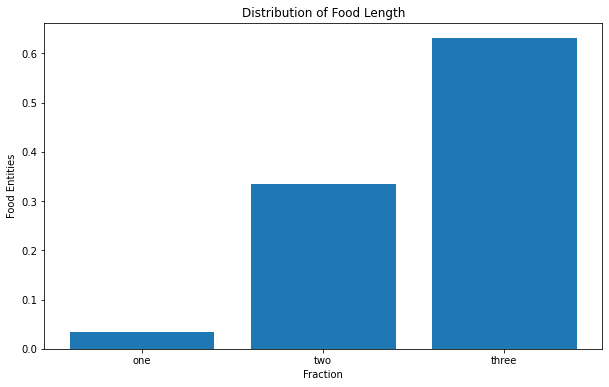

In [15]:
# lets get an idea of the training set, splitting all the foods by word length 
one_word_food_list = foods_list[foods_list.str.split().apply(len) == 1]
two_word_food_list = foods_list[foods_list.str.split().apply(len) == 2]
three_word_food_list = foods_list[foods_list.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_word_food_list.size/foods_list.size, two_word_food_list.size/foods_list.size, 
                   three_word_food_list.size/foods_list.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Distribution of Food Length")
plt.xlabel("Fraction")
plt.ylabel("Food Entities")

# display the plot
plt.show()

#### This is a very unbalanced dataset, with majority (~60%) of the branded food being three-worded. There's a good chance that spaCy develops a bias for 3-worded food items and fails to identify the one/two-worded food items. Rebalancing the dataset is necessary, and I'm starting with a simple 40/30/30 split between one/two/three words, respectively. We obviously want to include all the one-worded sites, and accordingly sample fractions from two and three-worded items

In [16]:
one_word_food_list.size

1378

In [17]:
# start sampling from the three lists
sample_size = round(one_word_food_list.size / 40 * 100)

sample_size

3445

In [18]:
# let's sample from two and three-worded items, shuffled for randomness

two_word_samples = two_word_food_list.sample(frac=1)
three_word_samples = three_word_food_list.sample(frac=1)

# build the final foods list 
foods_final_list = one_word_food_list.append(two_word_samples[:round(sample_size * 0.30)]).append(three_word_samples[:round(sample_size * 0.30)])


In [19]:
# sanity check the lengths

for i in range(3):
    print(f"{i+1}-worded food entities:", foods_final_list[foods_final_list.str.split().apply(len) == i + 1].size)

1-worded food entities: 1378
2-worded food entities: 1034
3-worded food entities: 1034


### Building a Train Test Split for food entities
<b>We need to build multiple lists with placeholders for these food entities to be inserted into, lets build that<b>

In [20]:
possible_food_placeholders = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

In [21]:
# create dictionaries to store the generated food combinations
training_set = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

testing_set = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

In [22]:
# Setting a sentence limit so that there's consitency across all word lengths, let's start building some sentences!
FOOD_SENTENCE_LIMIT = 256

In [23]:
def build_sentences(count):
    return {
        1: training_set["one_food"] if len(training_set["one_food"]) < FOOD_SENTENCE_LIMIT else testing_set["one_food"],
        2: training_set["two_foods"] if len(training_set["two_foods"]) < FOOD_SENTENCE_LIMIT else testing_set["two_foods"],
        3: training_set["three_foods"] if len(training_set["three_foods"]) < FOOD_SENTENCE_LIMIT else testing_set["three_foods"],
    }[count]

In [24]:
replace_paranthesis = '{}'

foods_final_list = foods_final_list.sample(frac=1)
stopping_cond = foods_final_list.size -1

while stopping_cond >= 2:
    entities = []

    # pick a random food template
    template = possible_food_placeholders[random.randint(0, len(possible_food_placeholders) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(replace_paranthesis, template)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food_list = foods_final_list.iloc[stopping_cond]
        stopping_cond -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        template = template.replace(match, food_list, 1)
        match_span = re.search(food_list, template).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    build_sentences(len(matches)).append((template, {"entities": entities}))

In [25]:
# print the number of food sentences, as well as an example sentence
for key in training_set:
    print("{} {} sentences: {}".format(len(training_set[key]), key, training_set[key][0]))

256 one_food sentences: ('I had a bowl of refreshers', {'entities': [(16, 26, 'FOOD')]})
256 two_foods sentences: ('today I ate a sleigh ride jimmies and a aguas frescas juice for lunch', {'entities': [(14, 33, 'FOOD'), (40, 59, 'FOOD')]})
256 three_foods sentences: ('I ate a tweety gum ball with panino and surcralose just now', {'entities': [(8, 23, 'FOOD'), (29, 35, 'FOOD'), (40, 50, 'FOOD')]})


In [26]:
for key in testing_set:
    print("{} {} items: {}".format(len(testing_set[key]), key, testing_set[key][0]))

1023 one_food items: ("I made ringpop for yesterday's dinner", {'entities': [(7, 14, 'FOOD')]})
189 two_foods items: ('last night, a specialty brewed bars was sent to me with homestyle orange juice', {'entities': [(14, 35, 'FOOD'), (56, 78, 'FOOD')]})
169 three_foods items: ('I took a sprinkled donut holes, dressing and flounder fillets on the weekend', {'entities': [(9, 30, 'FOOD'), (32, 40, 'FOOD'), (45, 61, 'FOOD')]})


### Revision Data Generation
#### Generating spaCy entities in order to ensure that the model doesn't forget to recognize and differentiate other entities. We want the model to recognize FOOD-related entities, but also not forget how to recognize PERSON or ORG

In [27]:
npr_df = pd.read_csv("../../Branded_Food/npr.csv")
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [28]:
# create an nlp object as we'll use this to seperate the sentences and identify existing entities
nlp = en_core_web_lg.load()

In [29]:
# This cell takes a while to run, this will create spaCy objects which will allow the model to identify sentences
# more effectively. Also doing some text cleaning to ensure execessive whitespaces don't mess up model training

spacy_sentence_objects = []

for doc_sentences in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc_sentences.sents:
        if  40 < len(sentence.text) < 80:
            # trimming additional whitespaces
            spacy_sentence_objects.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [30]:
spacy_sentence_objects[9]

'We are about to find out whether it works for him in the Oval Office.'

In [31]:
# Use the pre-exisitng spaCy model to predict the above entities from the spaCy objects created above

sentence_object_entities = []

# disabling some compenents that aren't need for this tagging
for doc in nlp.pipe(spacy_sentence_objects, batch_size=50, disable=["tagger", "parser"]):
    
    if len(doc.ents) > 0:
        sentence_object_entities.append((doc.text, {'entities': [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

#### Train Test Split for above revision data

In [32]:
# Check to see the kind of entities and corresponding sentences created
sentence_object_entities[0]

('And in that sense, this year shows little sign of ending on Dec. 31.',
 {'entities': [(19, 28, 'DATE'), (60, 67, 'DATE')]})

In [33]:
sentences_train = []
sentences_test = []

train_sentence_entities = {}
test_sentence_entities = {}

# ensure that entities are evenly distributed 
entity_limit = 100

In [34]:
# function to add to or add a new entity into the train and test sentence_entitiy dicts
def append_entities(sentence_entity, entities):
    for entity in entities:
        label = entity[2]
        if label in sentence_entity:
            sentence_entity[label] +=1
        else:
            sentence_entity[label] = 1

In [35]:
random.shuffle(sentence_object_entities)
for sentence_object_entity in sentence_object_entities:
    sentence_entities = sentence_object_entity[1]['entities']
    
    # preserve distribution of entities
    
    should_append_to_train_counter = 0
    for _, _, label in sentence_entities:
        if label in train_sentence_entities and train_sentence_entities[label] > entity_limit:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1
    
    if should_append_to_train_counter >= 0:
        sentences_train.append(sentence_object_entity)
        append_entities(train_sentence_entities, sentence_entities)
        
    else:
        sentences_test.append(sentence_object_entity)
        append_entities(test_sentence_entities, sentence_entities)

In [36]:
# sample sentence in the training set
sentences_train[1]

('Victor Vardanyan, 14, isn’t having any of it.',
 {'entities': [(0, 16, 'PERSON'), (18, 20, 'DATE')]})

In [37]:
# set of entities and corresponding count for each
train_sentence_entities

{'PERSON': 283,
 'ORG': 175,
 'DATE': 202,
 'GPE': 173,
 'TIME': 105,
 'CARDINAL': 165,
 'LANGUAGE': 57,
 'LOC': 103,
 'WORK_OF_ART': 103,
 'PERCENT': 103,
 'NORP': 119,
 'MONEY': 103,
 'FAC': 101,
 'ORDINAL': 108,
 'PRODUCT': 101,
 'QUANTITY': 102,
 'EVENT': 101,
 'LAW': 68}

### Training the NER Model

In [38]:
# take the FOOD entities dataset we created, combine it with the entities we pulled above to generate full
# training dataset for our model

train_food_data = training_set['one_food'] + training_set['two_foods'] + training_set['three_foods']
training_dataset = train_food_data + sentences_train

len(training_dataset)

2237

#### Begin Training

In [39]:
# Got some backwards compatibilty issues with spaCy 3.0 which wasn't letting me pass a tuple of text,annotation from 
# each batch to update the spaCy model after each epoch. Found a fix in the following stackoverflow link and
# model training ran without any issues: 
# https://stackoverflow.com/questions/66675261/how-can-i-work-with-example-for-nlp-update-problem-with-spacy3-0
from spacy.training.example import Example

In [40]:
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = training_dataset
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            for text, annotations in batch:
                # create Example
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Update the model
                nlp.update([example], losses=losses, drop=0.3)
        
        
#             texts, annotations = zip(*batch)
#             nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

/opt/anaconda3/lib/python3.8/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "last night, a maraschino  was sent to me with supe..." with entities "[(14, 25, 'FOOD'), (46, 65, 'FOOD')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "I tasted some squid, chili  and tamari at the offi..." with entities "[(14, 19, 'FOOD'), (21, 27, 'FOOD'), (32, 38, 'FOO...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/thinc/layers/layernorm.py:32: RuntimeWarning: invalid value encountered in reciprocal
  

Losses (1/30) {'ner': 2703.077169579256}
Losses (2/30) {'ner': 1931.2139001460682}
Losses (3/30) {'ner': 1726.14052586148}
Losses (4/30) {'ner': 1396.8121460458392}
Losses (5/30) {'ner': 1428.7386245231953}
Losses (6/30) {'ner': 1331.9970612899378}
Losses (7/30) {'ner': 1194.7557940984898}
Losses (8/30) {'ner': 1130.0148696524684}
Losses (9/30) {'ner': 1115.0880284913442}
Losses (10/30) {'ner': 1137.1554022052705}
Losses (11/30) {'ner': 1154.4348062950503}
Losses (12/30) {'ner': 899.5330902962265}
Losses (13/30) {'ner': 926.0241582892396}
Losses (14/30) {'ner': 954.4970741167981}
Losses (15/30) {'ner': 786.1835368354208}
Losses (16/30) {'ner': 857.1674080072206}
Losses (17/30) {'ner': 838.0437108206273}
Losses (18/30) {'ner': 853.1888739457121}
Losses (19/30) {'ner': 889.4009478446528}
Losses (20/30) {'ner': 699.4294989437983}
Losses (21/30) {'ner': 760.8884471947995}
Losses (22/30) {'ner': 732.2812125739636}
Losses (23/30) {'ner': 693.8578019967686}
Losses (24/30) {'ner': 645.23902080

### Model Evaluation

In [270]:
# display sentence involving original entities
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent")

In [42]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips and an apple for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

In [43]:
# testing on a sentence pulled from Eater Detroit, looks good!!
spacy.displacy.render(nlp("This southwest Detroit gem is a great spot to splurge on a steak flavored with "\
                          "poblano pepper or savor a plate of grilled fish tacos."), style="ent")
spacy.displacy.render(nlp("For a late-night taste of Detroit’s famous coney dog — a chili dog with mustard and "\
                    "onions on a steamed bun — there’s no better place to indulge than Duly’s Place."), style="ent")

#### Evaluating entity performance

In [44]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

In [45]:
# loop over data from our test food set (3 keys in total)
for key in training_set:
    foods = training_set[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [46]:
word_evaluation

{'1_worded_foods': {'correct': 589, 'total': 600},
 '2_worded_foods': {'correct': 469, 'total': 475},
 '3_worded_foods': {'correct': 458, 'total': 461}}

In [47]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 98.17%
2_worded_foods: 98.74%
3_worded_foods: 99.35%
---
one_food: 98.44%
two_foods: 98.63%
three_foods: 98.83%

Total: 98.70%


#### Revision Entity Evaluation

In [48]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

In [49]:
# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

In [50]:
# same as before, see if entities from test set match what spaCy currently predicts
for data in sentences_test:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")

In [51]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

PERSON | 84.70%
ORG | 46.39%
DATE | 72.71%
GPE | 79.38%
WORK_OF_ART | 50.16%
NORP | 88.71%
ORDINAL | 96.20%
CARDINAL | 75.24%
TIME | 64.74%
QUANTITY | 77.17%
EVENT | 67.65%
FAC | 49.33%
LOC | 70.27%
PERCENT | 88.91%
PRODUCT | 32.00%
MONEY | 77.44%
LAW | 58.33%
LANGUAGE | 94.12%

Overall accuracy: 73.21%


In [54]:
nlp.meta["name"] = "oystr_entity_extractor_v1"
nlp.to_disk("../models/v1")

## Load a stored Model and score Eater Dataset

In [4]:
spacy.__version__

'3.2.0'

In [3]:
nlp = spacy.load("../models/v1")

dictionary with key as restaurant name and each value is another dict with word and frequency count

In [227]:
eater_entities = defaultdict(lambda: defaultdict(int))

In [228]:
for key in restaurant_dict:
    for sentence in restaurant_dict[key]:
        doc = nlp(sentence)
        for ent in doc.ents:
            if ent.label_ == 'FOOD':
                if ent.text in eater_entities[key]:
                    eater_entities[key][ent.text] +=1
                else:
                    eater_entities[key][ent.text] =1

In [237]:
for key in eater_entities['Mink Detroit']:
    print(key)

various varieties
crab cholodnik
smoked watermelon
king prawn
clams
rice
grape
tahini ice cream
shrimp rolls
caviar
scallop crudo
clams in broth
dry
beef tartare
wine bar
fresh selection
shellfish
springy rolls
featured poached shrimp
lobster


In [244]:
 eater_entities['Louisiana Creole Gumbo']

defaultdict(int,
            {'loads of shrimp': 4,
             'sausage': 5,
             'vegetables': 5,
             'bayou favorites red beans': 4,
             'rice': 5,
             'jambalaya': 4,
             'shrimp': 6,
             'barbecue chicken meals': 1,
             'red beans': 1,
             'macaroni': 1,
             'cheese': 1})

In [256]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

sns.set(rc={'figure.figsize':(18,12)})

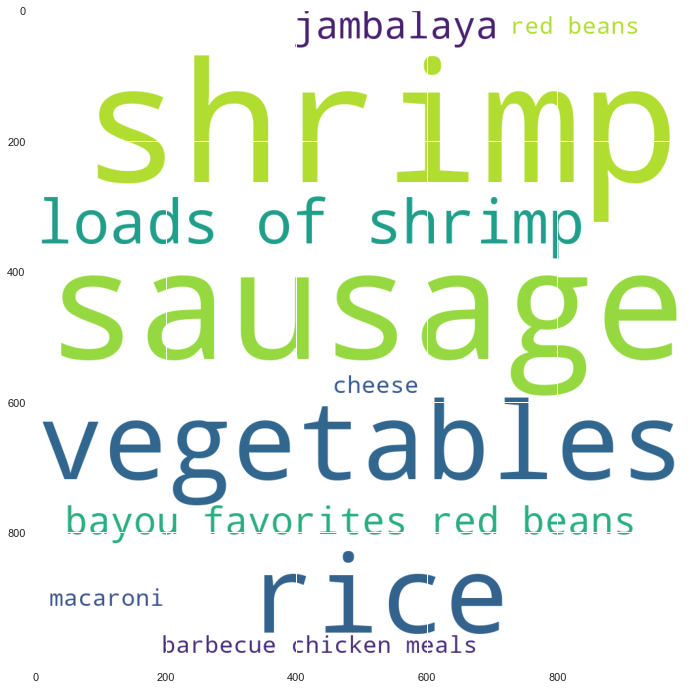

In [261]:
wc = WordCloud(background_color="white",width=1000,height=1000,normalize_plurals=False).generate_from_frequencies(eater_entities['Louisiana Creole Gumbo'])
plt.imshow(wc)

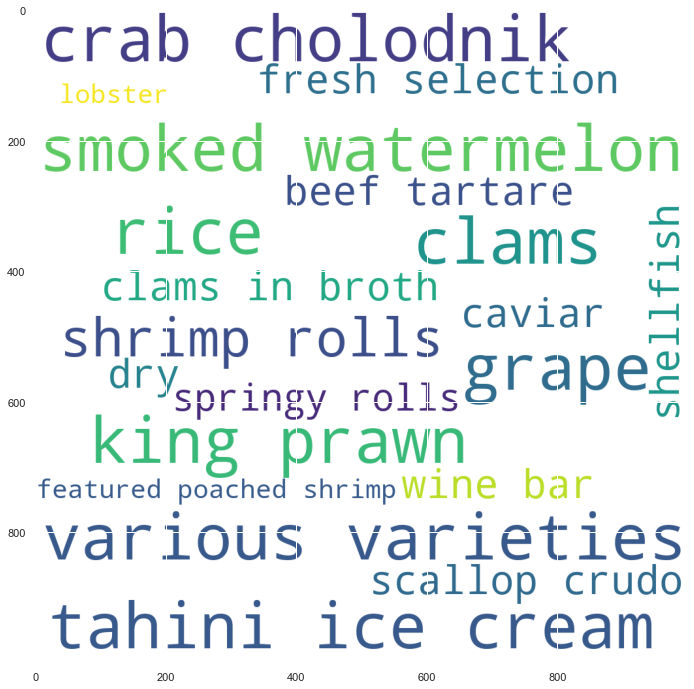

In [262]:
wc = WordCloud(background_color="white",width=1000,height=1000,normalize_plurals=False).generate_from_frequencies(eater_entities['Mink Detroit'])
plt.imshow(wc)

Text(0.5, 1.0, 'Food Categories for Mink Detroit')

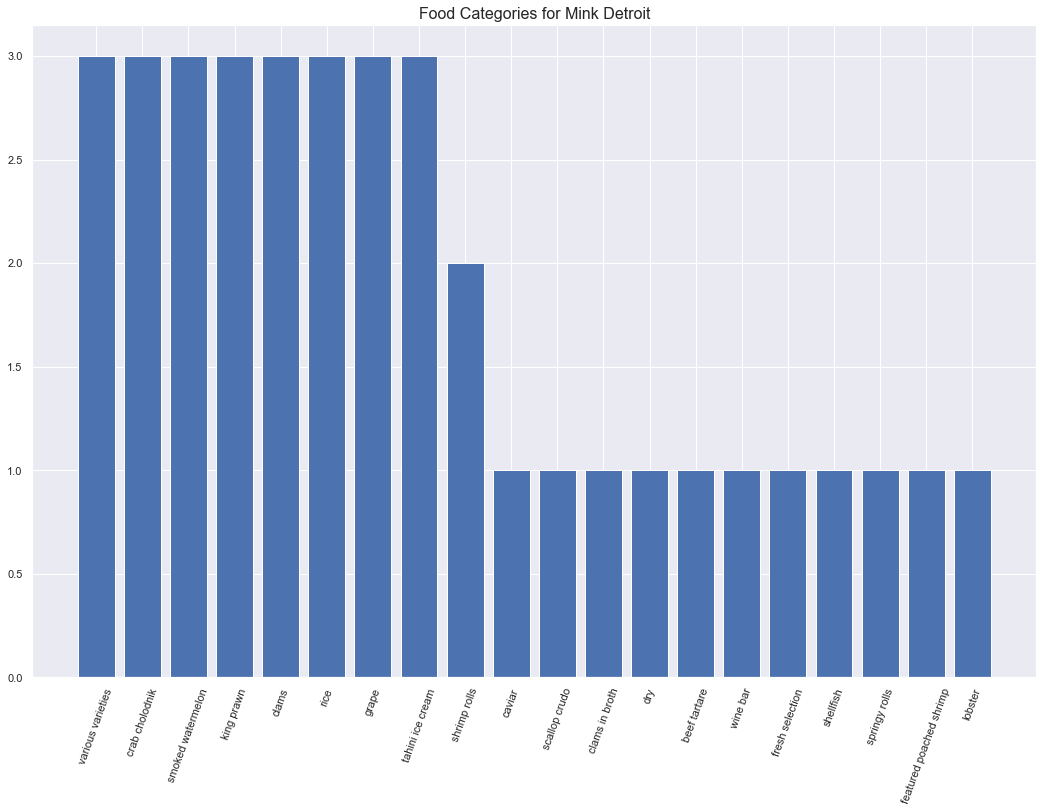

In [269]:
plt.bar(*zip(*eater_entities['Mink Detroit'].items()))
plt.xticks(rotation=70)
plt.title("Food Categories for Mink Detroit", size= 16)
# plt.bar(range(len()), list(eater_entities['Mink Detroit']), align='center')
# plt.xticks(range(len(eater_entities['Mink Detroit'])), list(eater_entities['Mink Detroit']))